In [1]:
%load_ext autoreload
%autoreload 2

import psutil
import dask.distributed   
import numpy as np
import xarray as xr
from odc.stac import stac_load
from pystac_client import Client

import warnings
warnings.filterwarnings("ignore", category=UserWarning, message="angle from rectified to skew grid parameter lost in conversion to CF")

In [2]:
# Get the available memory in gigabytes (to later adapt chunks size)

available_memory = psutil.virtual_memory().available
available_memory_gb = available_memory / (1024 ** 3)

print(f"Available memory: {available_memory_gb:.2f} GB")

Available memory: 4.61 GB


In [3]:
# Initiate Dask Env
client = dask.distributed.Client()
display(client)

/Users/pohle/miniconda3/envs/pystac_example/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 58324 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:58324/status,
Dashboard: http://127.0.0.1:58324/status,Workers: 4
Total threads: 8,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:58325,Workers: 0
Dashboard: http://127.0.0.1:58324/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:58336,Total threads: 2
Dashboard: http://127.0.0.1:58337/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:58328,


In [4]:
catalog = Client.open("https://explorer.swissdatacube.org/stac")

In [5]:
catalog

<Client id=sdc-explorer>

In [6]:
product = 's2_l2'
measurements = ["B04", "B05", "SCL"]
time = ("2024-04-01", "2024-04-15")

# longitude = (8.270401, 9.270401)
# latitude = (46.538201, 47.538201)
longitude = (9.270401, 9.329016)
latitude = (47.038201, 47.08)

resolution = -10.0, 10.0
output_crs = 'epsg:2056'

chunks = {"x": 1024, "y": 1024, "time": 1}  # 2048 values are OK with ~21Gb memory available

In [7]:
# Mask function
# See https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/scene-classification/
# for valid_cats
def create_scl_clean_mask(scl, valid_cats = [4, 5, 6, 7, 11]):
    return xr.apply_ufunc(np.isin, scl, valid_cats, dask='allowed')

In [8]:
# search items in catalog
query = catalog.search(
    collections=[product],
    datetime=f"{time[0]}/{time[1]}", limit=100,
    bbox=(longitude[0], latitude[0],
          longitude[1], latitude[1])
)
items = list(query.items())

In [9]:
%%time

# load identified items
lazy_ds = stac_load(
    items,
    lon=longitude,
    lat=latitude,
    bands=measurements,
    crs=output_crs,
    resolution=resolution[1],
    chunks=chunks,
)

# remove nodata
lazy_ds = lazy_ds.where(create_scl_clean_mask(lazy_ds.SCL)).drop_vars('SCL')

# manage tiles daily overlays
lazy_ds['time'] = lazy_ds['time'].to_index().to_period('D').to_timestamp()
if len(list(lazy_ds['time'].values)) != len(set(lazy_ds['time'].values)):
    lazy_ds = lazy_ds.groupby('time').mean(dim='time', skipna=True)

# convert DN to SR (and remove saturated pixels)
lazy_ds = lazy_ds.where(lazy_ds <= 10000) / 10000

# compute daily NDCI
ndci = (lazy_ds.B05 - lazy_ds.B04) / (lazy_ds.B05 + lazy_ds.B04)

# compute mean and cnt (number of pixels with data)
ndci = ndci.mean(dim='time')
cnt = np.isfinite(lazy_ds.B04).sum(dim='time')

CPU times: user 37.7 ms, sys: 4.06 ms, total: 41.8 ms
Wall time: 42.6 ms


In [10]:
%%time

# Perform calculation (you can open the link generated by
# "Initiate Dask Env" cell to monitor how your resources are used
ndci_sdc = ndci.load()
# cnt_sdc = cnt.load()

CPU times: user 167 ms, sys: 65.9 ms, total: 233 ms
Wall time: 4.09 s


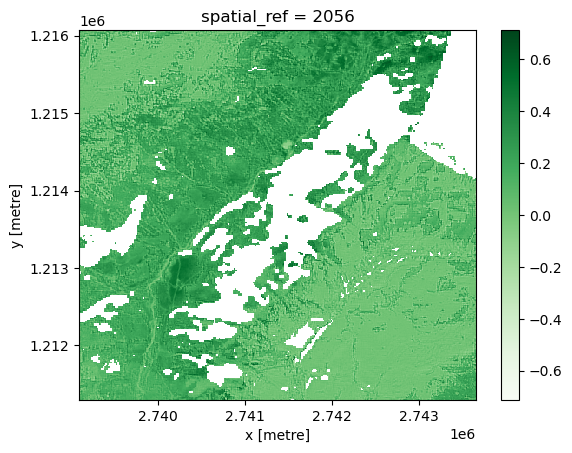

In [11]:
ndci_sdc.plot(cmap='Greens')

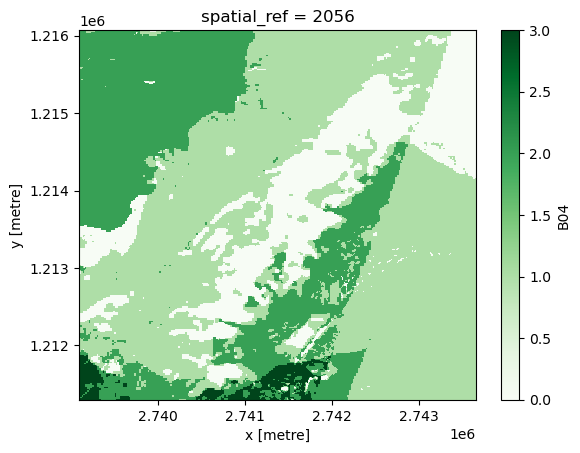

In [12]:
cnt.plot(cmap='Greens')